<a href="https://colab.research.google.com/github/coryellj4/4540/blob/main/Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First we load all packages we will need to use

*   List item
*   List item



In [228]:
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.signal import welch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import h5py

Next, we load and label the dataset. I found that combining all three subjects into a single dataset yielded the best classification results.

In [229]:
filepaths = [
    'Rat08-20130711_017.h5',
    'Part1SubjectHB10.h5',
    'Part2SubjectHB13.h5'
]

def load_all_lfp(filepaths):
    all_lfp = {'NREM': [], 'WAKE': []}
    fs_global = None
    for filepath in filepaths:
        f = h5py.File(filepath, 'r')
        fs = f.attrs['fs'][0]
        if fs_global is None:
            fs_global = fs
        print(f"\nLoading {filepath} | Sampling rate: {fs:.1f} Hz")
        for state in ['NREM', 'WAKE']:
            for i in range(len(f[state])):
                all_lfp[state].append(f[state][str(i+1)][()].astype(float))
    return all_lfp, fs_global

lfp, fs = load_all_lfp(filepaths)



Loading Rat08-20130711_017.h5 | Sampling rate: 1250.0 Hz

Loading Part1SubjectHB10.h5 | Sampling rate: 1000.0 Hz

Loading Part2SubjectHB13.h5 | Sampling rate: 1000.0 Hz


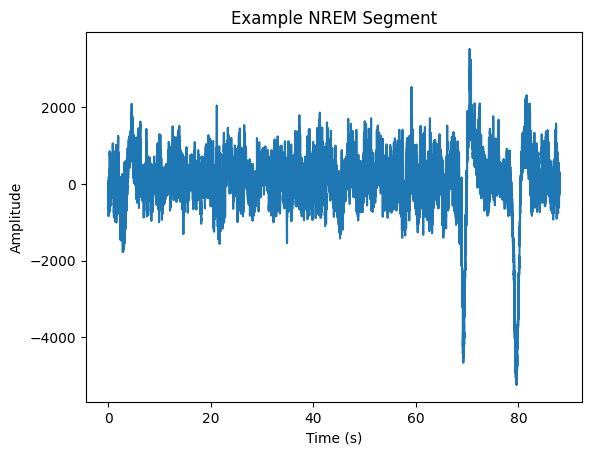

In [230]:
x = lfp['NREM'][0]
t = np.arange(x.size) / fs
plt.plot(t, x)
plt.title("Example NREM Segment")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


In [231]:
def extract_features(clip, fs):
    mean = np.mean(clip)
    std = np.std(clip)
    skew = stats.skew(clip)
    kurt = stats.kurtosis(clip)
    freqs, psd = welch(clip, fs=fs, nperseg=fs//2)
    psd_features = np.log10(psd + 1e-8)[:20]  # First 20 PSD bins
    return np.concatenate(([mean, std, skew, kurt], psd_features))


Here, we perform feature engineering by adding statistical features such as standard deviation, mean, skewness, and kurtosis

In [232]:
class LFPDataset(Dataset):
    def __init__(self, lfp_dict, fs, clip_len_sec=5, overlap=0.5):
        self.X, self.y = [], []
        clip_len = int(fs * clip_len_sec)
        stride = int(clip_len * (1 - overlap))

        for label, state in enumerate(['WAKE', 'NREM']):
            for segment in lfp_dict[state]:
                segment = segment.squeeze()
                for start in range(0, len(segment) - clip_len + 1, stride):
                    clip = segment[start:start + clip_len]
                    features = extract_features(clip, fs)
                    self.X.append(features)
                    self.y.append(label)

        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


Here we split the data into an 80/20 training/testing split, and load the data into the model.

In [233]:
dataset = LFPDataset(lfp, fs)
train_idx, test_idx = train_test_split(range(len(dataset)), test_size=0.2, stratify=dataset.y)
train_loader = DataLoader(torch.utils.data.Subset(dataset, train_idx), batch_size=32, shuffle=True)
test_loader = DataLoader(torch.utils.data.Subset(dataset, test_idx), batch_size=32)

In this section, we define the model architecture — a fully connected (feedforward) neural network designed to classify LFP segments into brain states.

In [234]:
class FeedforwardNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.net(x)

We initialize the model and set the loss function to Cross Entropy, which is well-suited for classification tasks.

In [235]:
model = FeedforwardNet(input_size=24)  # 4 stats + 20 PSD bins
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Here we train the model, and keep track of some metrics


In [236]:
epochs = 200
train_losses, val_accuracies, f1_scores = [], [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        out = model(x)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    model.eval()
    correct, all_preds, all_labels = 0, [], []
    with torch.no_grad():
        for x, y in val_loader:
            logits = model(x)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.numpy())
            all_labels.extend(y.numpy())
            correct += (preds == y).sum().item()

    val_acc = correct / len(val_loader.dataset)
    val_accuracies.append(val_acc)
    f1 = f1_score(all_labels, all_preds)
    f1_scores.append(f1)
    if(epoch%10==0):
        print(f"Epoch {epoch+1}: loss={train_losses[-1]:.4f}, val_acc={val_acc:.4f}, f1={f1:.4f}")

Epoch 1: loss=0.9187, val_acc=0.6186, f1=0.2940
Epoch 11: loss=0.5725, val_acc=0.7088, f1=0.2809
Epoch 21: loss=0.2856, val_acc=0.9088, f1=0.8531
Epoch 31: loss=0.2239, val_acc=0.9118, f1=0.8628
Epoch 41: loss=0.1929, val_acc=0.9167, f1=0.8741
Epoch 51: loss=0.1833, val_acc=0.9147, f1=0.8634
Epoch 61: loss=0.1855, val_acc=0.9294, f1=0.8932
Epoch 71: loss=0.1687, val_acc=0.8804, f1=0.8436
Epoch 81: loss=0.1706, val_acc=0.9235, f1=0.8777
Epoch 91: loss=0.1672, val_acc=0.9294, f1=0.8882
Epoch 101: loss=0.1726, val_acc=0.9216, f1=0.8870
Epoch 111: loss=0.1651, val_acc=0.9304, f1=0.8929
Epoch 121: loss=0.1535, val_acc=0.9353, f1=0.9062
Epoch 131: loss=0.1593, val_acc=0.9167, f1=0.8657
Epoch 141: loss=0.1646, val_acc=0.9333, f1=0.8963
Epoch 151: loss=0.1577, val_acc=0.9510, f1=0.9290
Epoch 161: loss=0.1510, val_acc=0.9284, f1=0.8885
Epoch 171: loss=0.1557, val_acc=0.9353, f1=0.9012
Epoch 181: loss=0.1570, val_acc=0.9412, f1=0.9155
Epoch 191: loss=0.1515, val_acc=0.9324, f1=0.9013


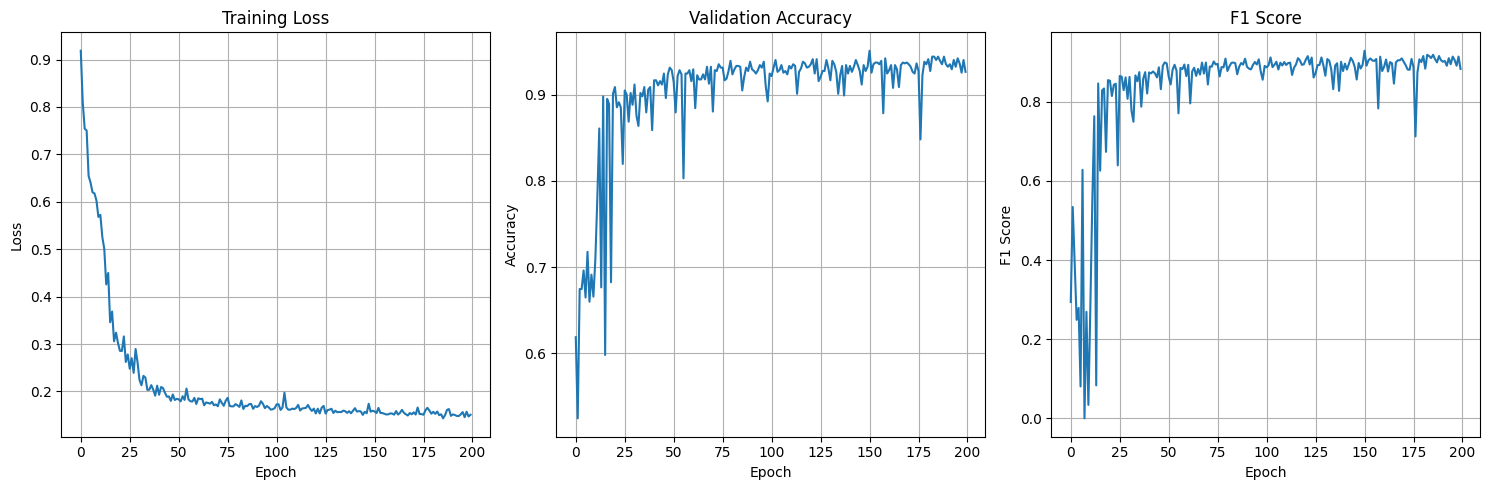

In [237]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.grid(True)

plt.subplot(1,3,3)
plt.plot(f1_scores, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.grid(True)

plt.tight_layout()
plt.show()

Here we can evaluate the Model with the Test data, which it has not seen before.



Accuracy: 0.9444995044598612

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      1340
           1       0.96      0.87      0.91       678

    accuracy                           0.94      2018
   macro avg       0.95      0.93      0.94      2018
weighted avg       0.94      0.94      0.94      2018

Confusion Matrix:
 [[1313   27]
 [  85  593]]


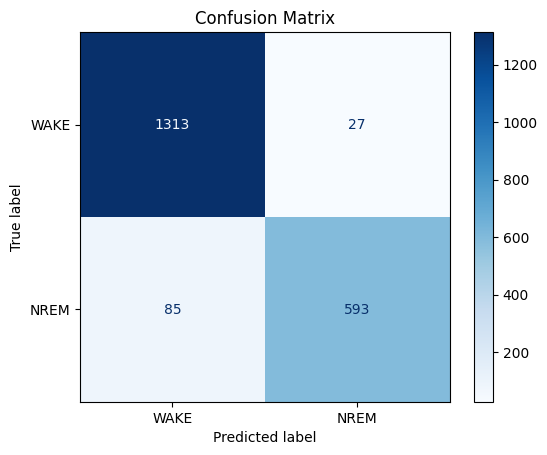

In [238]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        logits = model(x)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.numpy())
        all_labels.extend(y.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print("\nAccuracy:", accuracy)
print("\nClassification Report:\n", classification_report(all_labels, all_preds))
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)
ConfusionMatrixDisplay(cm, display_labels=['WAKE', 'NREM']).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

This assignment was mostly straightforward but required a bit of experimentation to get good results. I started by loading and plotting data from one subject, but eventually I merged all three datasets to get more training samples and improve generalization. Initially, I was just feeding raw clips into the model, but the performance wasn't ideal, so I added some basic statistical features—mean, standard deviation, skewness, and kurtosis—along with some power spectral density features to give the model more to work with.

One thing that helped boost accuracy was using overlapping clips instead of just slicing the signal into non-overlapping chunks. This gave the model more training data and made it better at handling transitions between states. After adding that and tuning a few hyperparameters, the model reached around 94% accuracy. Overall, it mostly came down to trying different feature combinations and making sure the dataset was big enough and balanced. Not too exciting, but it worked